# Correlogram Analysis

This notebook analyzes the results from correlogram experiments.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Define problem ordering
problem_ordering = [
    'OneMax', 
    #'HelloWorld', 
    'Sphere',
    #'TSP', 
    #'NeuralNetwork',
    'BFS-CNF',
    'BFS-Full', 
    'BFS-EvenParity',
    #'GrammaticalEvolution', 
    ]

## 1. Summary Statistics from Main Results

Read the main CSV results file and create a grouped summary table.

In [75]:
# Read main results file
df = pd.read_csv('outputs/results_2026_01_07_correlogram.csv')
df.head()

,Unnamed: 0,problem,size,size_cat,solver,budget,dist_type,name_type,generator,rep,elapsed,cor_length,onestep_cor,diameter,sr_structural_change_cor,sr_average_parent_length
0,0,OneMax,10,small,correlogram,10000,coarse,lin,one-max,0,1.345315,4.706621,0.788464,9.94,0.0,0.0
1,1,OneMax,10,small,correlogram,10000,coarse,str,one-max,0,0.019925,4.706621,0.788464,9.94,0.0,0.0
2,2,OneMax,50,medium,correlogram,50000,coarse,lin,one-max,0,0.072911,7.000000,0.855739,50.40,0.0,0.0
3,3,OneMax,50,medium,correlogram,50000,coarse,str,one-max,0,0.100696,7.000000,0.855739,50.40,0.0,0.0
4,4,OneMax,100,large,correlogram,200000,coarse,lin,one-max,0,0.190285,2.071406,0.816680,100.30,0.0,0.0


In [76]:
# Create groupby table across problem / size / dist_type / name_type
# Note: The main results file should have columns for diameter, cor_length, and onestep_cor
# If there are multiple reps, we'll aggregate (mean)

groupby_cols = ['problem', 'size', 'dist_type', 'name_type', 'generator']

summary_cols = ['diameter', 'cor_length', 'onestep_cor', 'sr_structural_change_cor', 'sr_average_parent_length']

summary_table = df.groupby(groupby_cols)[summary_cols].mean()

# Apply problem ordering
summary_table = summary_table.reset_index()
summary_table['problem'] = pd.Categorical(summary_table['problem'], categories=problem_ordering, ordered=True)
summary_table = summary_table.sort_values(['problem', 'size', 'dist_type', 'name_type'])
summary_table = summary_table.set_index(groupby_cols)

summary_table

diameter  cor_length  \
problem        size dist_type name_type generator                              
OneMax         10   coarse    lin       one-max         9.940000    4.706621   
                              str       one-max         9.940000    4.706621   
               50   coarse    lin       one-max        50.400000    7.000000   
                              str       one-max        50.400000    7.000000   
               100  coarse    lin       one-max       100.300000    2.071406   
                              str       one-max       100.300000    2.071406   
Sphere         10   coarse    lin       sphere-gen     20.000000    3.024910   
                              str       sphere-gen     20.000000    3.024910   
               20   coarse    lin       sphere-gen     40.000000    2.889932   
                              str       sphere-gen     40.000000    2.889932   
               40   coarse    lin       sphere-gen     80.000000    2.500451   
                              str       sphere-gen     80.000000    2.500451   
BFS-CNF        6    coarse    lin       sr-depth-gen   25.430000    7.403781   
                              str       sr-depth-gen   31.580000    5.572641   
               12   coarse    lin       sr-depth-gen   40.591429    5.018953   
                              str       sr-depth-gen   50.853333    1.433407   
               18   coarse    lin       sr-depth-gen   61.984000    9.133391   
                              str       sr-depth-gen   81.629333    2.960294   
BFS-Full       6    coarse    lin       sr-depth-gen   25.430000    3.968574   
                              str       sr-depth-gen   31.580000    6.129875   
               12   coarse    lin       sr-depth-gen   40.591429    3.918080   
                              str       sr-depth-gen   50.853333    1.638841   
               18   coarse    lin       sr-depth-gen   61.984000    6.404718   
                              str       sr-depth-gen   81.629333   21.000000   
BFS-EvenParity 6    coarse    lin       sr-depth-gen   25.430000    6.079263   
                              str       sr-depth-gen   31.580000    5.189074   
               12   coarse    lin       sr-depth-gen   40.591429    3.325512   
                              str       sr-depth-gen   50.853333   10.886395   
               18   coarse    lin       sr-depth-gen   61.984000    2.089335   
                              str       sr-depth-gen   81.629333    1.039662   

                                                      onestep_cor  \
problem        size dist_type name_type generator                   
OneMax         10   coarse    lin       one-max          0.788464   
                              str       one-max          0.788464   
               50   coarse    lin       one-max          0.855739   
                              str       one-max          0.855739   
               100  coarse    lin       one-max          0.816680   
                              str       one-max          0.816680   
Sphere         10   coarse    lin       sphere-gen       0.676823   
                              str       sphere-gen       0.676823   
               20   coarse    lin       sphere-gen       0.724001   
                              str       sphere-gen       0.724001   
               40   coarse    lin       sphere-gen       0.611044   
                              str       sphere-gen       0.611044   
BFS-CNF        6    coarse    lin       sr-depth-gen     0.436406   
                              str       sr-depth-gen     0.482239   
               12   coarse    lin       sr-depth-gen     0.762287   
                              str       sr-depth-gen     0.269891   
               18   coarse    lin       sr-depth-gen     0.715702   
                              str       sr-depth-gen     0.623883   
BFS-Full       6    coarse    lin       sr-depth-gen     0.427764   
                              str       sr-dep

In [77]:
# Save the summary table to CSV
summary_table.to_csv('outputs/correlogram_summary_table.csv')
print("Summary table saved to outputs/correlogram_summary_table.csv")

# Export to LaTeX
latex_str = summary_table.to_latex(float_format="%.3f")
with open('outputs/correlogram_summary_table.tex', 'w') as f:
    f.write(latex_str)
print("Summary table saved to outputs/correlogram_summary_table.tex")

Summary table saved to outputs/correlogram_summary_table.csv
Summary table saved to outputs/correlogram_summary_table.tex


## 2. Plot Correlogram Curves

Read each xy results file and create plots in PDF format.

In [78]:
# Find all xy CSV files
xy_files = glob.glob('outputs/results_2026_01_07_correlogram_xy_*.csv')
print(f"Found {len(xy_files)} xy files to plot")

Found 30 xy files to plot


In [79]:
len(xy_files)

30

In [80]:
sorted(xy_files)

['outputs/results_2026_01_07_correlogram_xy_BFS-CNF_12_medium_50000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_12_medium_50000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_18_large_200000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_18_large_200000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_6_small_10000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_6_small_10000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-EvenParity_12_medium_50000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-EvenParity_12_medium_50000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-EvenParity_18_large_200000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-EvenPari

In [81]:
# Create plots for each xy file and save as PDF
for xy_file in xy_files:
    # Read the xy data
    xy_df = pd.read_csv(xy_file)
    
    # Extract metadata from filename
    # Format: results_2026_01_07_correlogram_xy_{problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_rep{rep}.csv
    filename = Path(xy_file).stem
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Log-scaled marker sizes based on n_axis
    if 'n_axis' in xy_df.columns:
        marker_sizes = np.log10(xy_df['n_axis'] + 1) * 30
    else:
        marker_sizes = 50  # default if n_axis not available
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, edgecolors='black', linewidth=0.5)
    plt.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=1, alpha=0.4, color='gray')
    plt.xlabel('Distance', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title(filename.replace('results_2026_01_07_correlogram_xy_', '').replace('_', ' '), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Add legend for marker sizes if n_axis is available
    if 'n_axis' in xy_df.columns:
        from matplotlib.lines import Line2D
        n_min, n_max = xy_df['n_axis'].min(), xy_df['n_axis'].max()
        n_reference = [10, 100, 1000, 10000, 100000]
        n_reference = [n for n in n_reference if n_min <= n <= n_max]
        if len(n_reference) > 0:
            legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor='gray', 
                                      markersize=np.sqrt(np.log10(n+1)*30/np.pi),
                                      label=f'n={n:,}') 
                               for n in n_reference]
            plt.legend(handles=legend_elements, title='Pairs per bin', loc='best', framealpha=0.9, fontsize=9)
        
        # Add text showing range
        plt.text(0.02, 0.98, f'n range: {int(n_min):,}-{int(n_max):,}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top',
                 fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Save as PDF
    pdf_filename = xy_file.replace('.csv', '.pdf')
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.close()
    
print(f"Created {len(xy_files)} PDF plots")

Created 30 PDF plots


## 3. Summary Statistics by Problem Type

Additional analysis grouping by different dimensions.

## 2b. Display Correlogram Plots in Grid

Display all correlogram plots in a grid layout within the notebook.

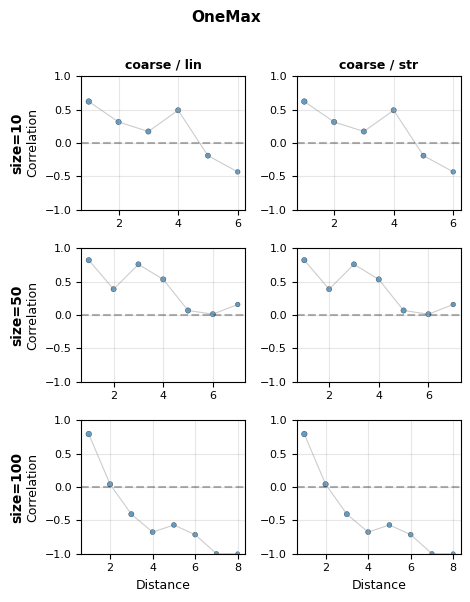

Created grid for OneMax with 3 sizes: [10, 50, 100]


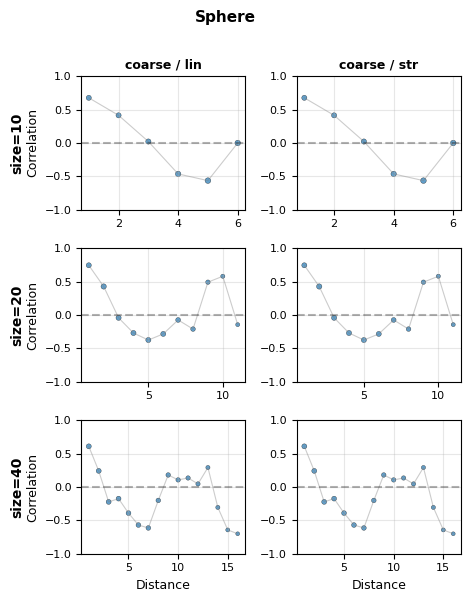

Created grid for Sphere with 3 sizes: [10, 20, 40]


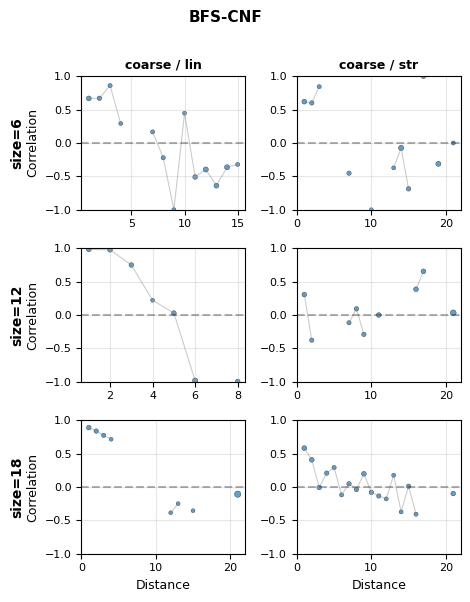

Created grid for BFS-CNF with 3 sizes: [6, 12, 18]


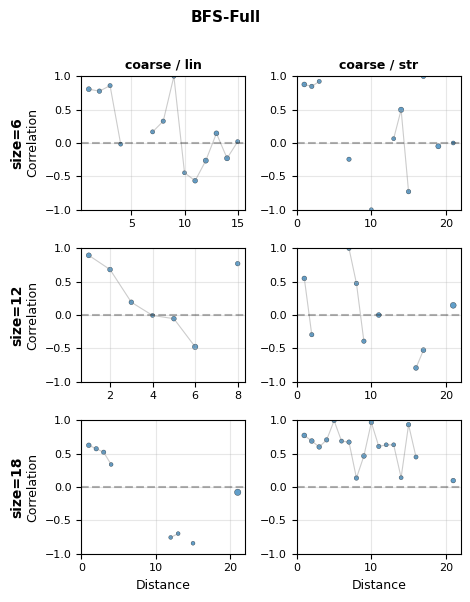

Created grid for BFS-Full with 3 sizes: [6, 12, 18]


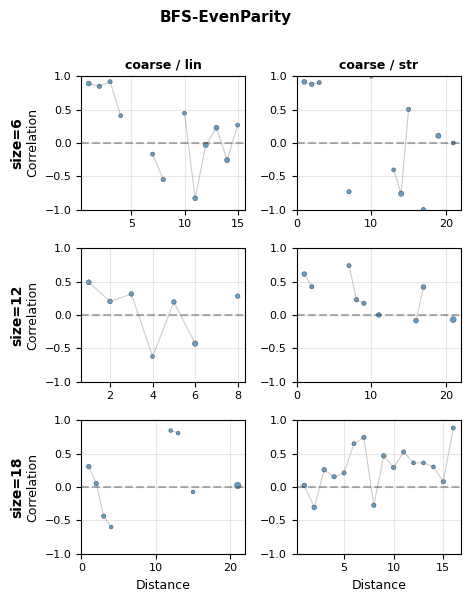

Created grid for BFS-EvenParity with 3 sizes: [6, 12, 18]
Created grids for 5 problems


In [82]:
# Create a grid of plots - one grid per problem
# Within each grid: rows = problem sizes, columns = name_type x dist_type

# Parse filenames to get metadata
plot_data = []
for xy_file in xy_files:
    filename = Path(xy_file).stem
    # Extract parts from filename
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Parse: {problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_{generator}_rep{rep}
    try:
        problem = parts[0]
        size = int(parts[1])
        size_cat = parts[2]
        budget = int(parts[3])
        dist_type = parts[4]
        name_type = parts[5]
        generator = parts[6]
        rep = parts[7].replace('rep', '')
        
        plot_data.append({
            'file': xy_file,
            'problem': problem,
            'size': size,
            'size_cat': size_cat,
            'budget': budget,
            'dist_type': dist_type,
            'name_type': name_type,
            'rep': rep
        })
    except:
        print(f"Warning: Could not parse {filename}")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)
plot_df['problem'] = pd.Categorical(plot_df['problem'], categories=problem_ordering, ordered=True)
plot_df = plot_df.sort_values(['problem', 'size', 'dist_type', 'name_type'])

# Get unique problems and combinations
problems = plot_df['problem'].unique()
dist_types = sorted(plot_df['dist_type'].unique())
name_types = sorted(plot_df['name_type'].unique())

# Create column labels for all combinations of dist_type x name_type
columns = [(dt, nt) for dt in dist_types for nt in name_types]

# Create one grid per problem
for problem in problems:
    problem_df = plot_df[plot_df['problem'] == problem]
    
    if len(problem_df) == 0:
        continue
    
    # Get sizes that actually exist for this problem
    sizes = sorted(problem_df['size'].unique())
    
    # Determine grid dimensions
    n_rows = len(sizes)
    n_cols = len(columns)
    
    # Create figure with smaller size - better for papers
    # Each subplot is 2.5" x 2" instead of 5" x 4"
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2*n_rows))
    
    # Handle case of single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{problem}', fontsize=11, fontweight='bold', y=0.995)
    
    # Plot each cell
    for row_idx, size in enumerate(sizes):
        for col_idx, (dist_type, name_type) in enumerate(columns):
            ax = axes[row_idx, col_idx]
            ax.set_ylim(-1, 1)
            
            # Find the matching file
            matching = problem_df[
                (problem_df['size'] == size) & 
                (problem_df['dist_type'] == dist_type) & 
                (problem_df['name_type'] == name_type)
            ]
            
            if len(matching) > 0:
                # Read the xy data
                xy_df = pd.read_csv(matching.iloc[0]['file'])
                
                # Log-scaled marker sizes based on n_axis (smaller for smaller figure)
                if 'n_axis' in xy_df.columns:
                    marker_sizes = np.log10(xy_df['n_axis'] + 1) * 10
                else:
                    marker_sizes = 15
                
                # Plot
                ax.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, 
                          edgecolors='black', linewidth=0.3)
                ax.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=0.8, 
                       alpha=0.4, color='gray')
            else:
                # No data for this combination (shouldn't happen now, but keep as fallback)
                ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=8, color='gray')
            
            # Formatting
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
            
            # Labels with appropriate font sizes for smaller figure
            if row_idx == n_rows - 1:
                ax.set_xlabel('Distance', fontsize=9)
            if col_idx == 0:
                ax.set_ylabel('Correlation', fontsize=9)
            
            # Tick label sizes
            ax.tick_params(axis='both', labelsize=8)
            
            # Row labels (size)
            if col_idx == 0:
                ax.text(-0.35, 0.5, f'size={size}', transform=ax.transAxes,
                       fontsize=10, va='center', ha='right', fontweight='bold',
                       rotation=90)
            
            # Column labels (dist_type, name_type)
            if row_idx == 0:
                ax.set_title(f'{dist_type} / {name_type}', fontsize=9, fontweight='bold')
    
    plt.tight_layout(rect=[0.03, 0, 1, 0.99])
    plt.savefig(f'outputs/correlogram_grid_{problem}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Created grid for {problem} with {len(sizes)} sizes: {sizes}")

print(f"Created grids for {len(problems)} problems")

In [83]:
# Group by problem only
by_problem = df.groupby('problem')[summary_cols].mean()
print("\nMean values by problem:")
by_problem


Mean values by problem:


,diameter,cor_length,onestep_cor,sr_structural_change_cor,sr_average_parent_length
problem,,,,,
BFS-CNF,48.678016,5.253745,0.548401,0.231996,15.641333
BFS-EvenParity,48.678016,4.768207,0.489273,0.198973,15.641333
BFS-Full,48.678016,7.176681,0.636309,0.425591,15.641333
OneMax,53.546667,4.592676,0.820294,0.000000,0.000000
Sphere,46.666667,2.805098,0.670623,0.000000,0.000000


In [84]:
# Group by size only
by_size = df.groupby('size')[summary_cols].mean()
print("\nMean values by size:")
by_size


Mean values by size:


,diameter,cor_length,onestep_cor,sr_structural_change_cor,sr_average_parent_length
size,,,,,
6,28.505000,5.723868,0.568255,0.218715,9.5548
10,14.970000,3.865765,0.732644,0.000000,0.0000
12,45.722381,4.370198,0.537707,0.212474,14.7896
18,71.806667,7.104567,0.568021,0.425371,22.5796
20,40.000000,2.889932,0.724001,0.000000,0.0000
40,80.000000,2.500451,0.611044,0.000000,0.0000
50,50.400000,7.000000,0.855739,0.000000,0.0000
100,100.300000,2.071406,0.816680,0.000000,0.0000


In [85]:
# Group by dist_type and name_type
by_type = df.groupby(['dist_type', 'name_type'])[summary_cols].mean()
print("\nMean values by dist_type and name_type:")
by_type


Mean values by dist_type and name_type:


diameter  cor_length  onestep_cor  \
dist_type name_type                                       
coarse    lin        45.643752    4.635662     0.607429   
          str        52.855200    5.202901     0.658531   

                     sr_structural_change_cor  sr_average_parent_length  
dist_type name_type                                                      
coarse    lin                        0.114946                   9.40052  
          str                        0.227678                   9.36908

In [86]:
# Group by problem, size, and name_type
groupby_cols = ['problem', 'size', 'name_type']
summary_cols = ['diameter', 'cor_length', 'onestep_cor', 'sr_structural_change_cor', 'sr_average_parent_length']

correlation_summary = df.groupby(groupby_cols)[summary_cols].mean()

# Apply problem ordering
correlation_summary = correlation_summary.reset_index()
correlation_summary['problem'] = pd.Categorical(correlation_summary['problem'], categories=problem_ordering, ordered=True)
correlation_summary = correlation_summary.sort_values(['problem', 'size', 'name_type'])
correlation_summary = correlation_summary.set_index(groupby_cols)

correlation_summary

diameter  cor_length  onestep_cor  \
problem        size name_type                                        
OneMax         10   lin          9.940000    4.706621     0.788464   
                    str          9.940000    4.706621     0.788464   
               50   lin         50.400000    7.000000     0.855739   
                    str         50.400000    7.000000     0.855739   
               100  lin        100.300000    2.071406     0.816680   
                    str        100.300000    2.071406     0.816680   
Sphere         10   lin         20.000000    3.024910     0.676823   
                    str         20.000000    3.024910     0.676823   
               20   lin         40.000000    2.889932     0.724001   
                    str         40.000000    2.889932     0.724001   
               40   lin         80.000000    2.500451     0.611044   
                    str         80.000000    2.500451     0.611044   
BFS-CNF        6    lin         25.430000    7.403781     0.436406   
                    str         31.580000    5.572641     0.482239   
               12   lin         40.591429    5.018953     0.762287   
                    str         50.853333    1.433407     0.269891   
               18   lin         61.984000    9.133391     0.715702   
                    str         81.629333    2.960294     0.623883   
BFS-Full       6    lin         25.430000    3.968574     0.427764   
                    str         31.580000    6.129875     0.755394   
               12   lin         40.591429    3.918080     0.652374   
                    str         50.853333    1.638841     0.457179   
               18   lin         61.984000    6.404718     0.624892   
                    str         81.629333   21.000000     0.900250   
BFS-EvenParity 6    lin         25.430000    6.079263     0.555250   
                    str         31.580000    5.189074     0.752478   
               12   lin         40.591429    3.325512     0.472447   
                    str         50.853333   10.886395     0.612064   
               18   lin         61.984000    2.089335    -0.008439   
                    str         81.629333    1.039662     0.551838   

                               sr_structural_change_cor  \
problem        size name_type                             
OneMax         10   lin                        0.000000   
                    str                        0.000000   
               50   lin                        0.000000   
                    str                        0.000000   
               100  lin                        0.000000   
                    str                        0.000000   
Sphere         10   lin                        0.000000   
                    str                        0.000000   
               20   lin                        0.000000   
                    str                        0.000000   
               40   lin                        0.000000   
                    str                        0.000000   
BFS-CNF        6    lin                        0.243497   
                    str                        0.377308   
               12   lin                        0.009248   
                    str                        0.277848   
               18   lin                        0.106292   
                    str                        0.377784   
BFS-Full       6    lin                        0.207443   
                    str                        0.339325   
               12   lin                        0.236449   
                    str                        0.411961   
               18   lin                        0.628177   
                    str                        0.730194   
BFS-EvenParity 6    lin                       -0.034440   
                    str                        0.179159   
               12   lin                        0.075035   
                    str                        0.264303   
               18   li

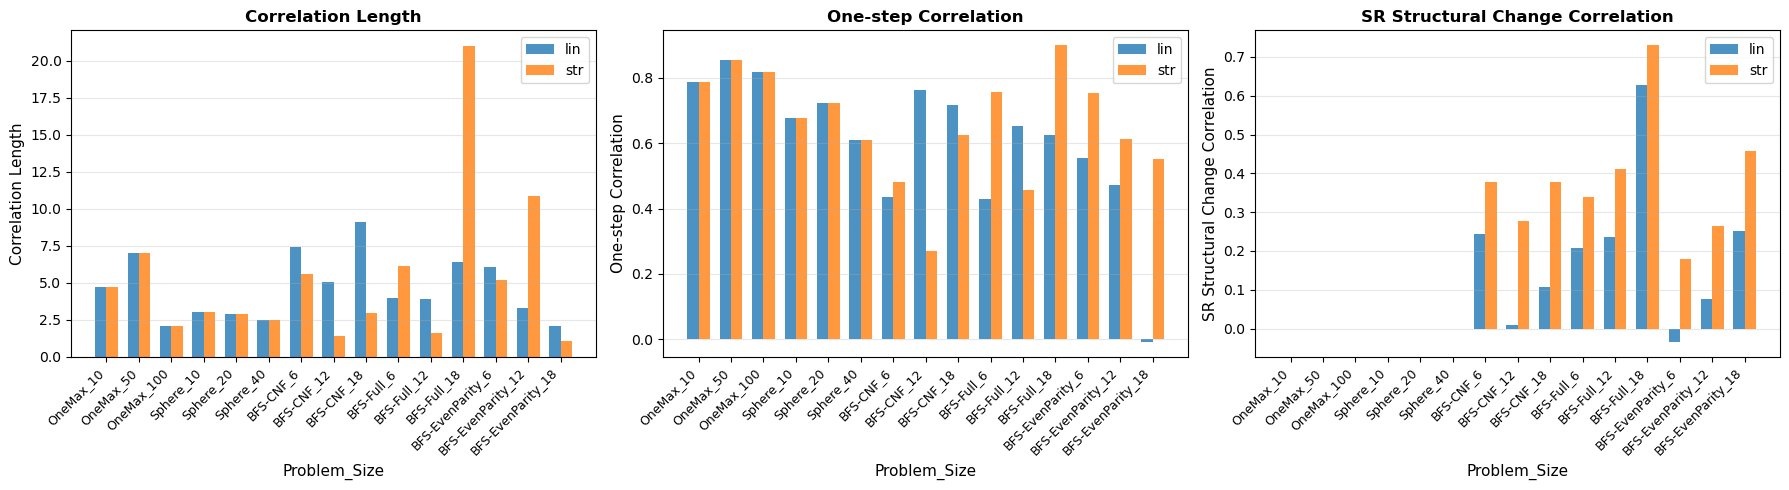

In [88]:
# Visualize the three key metrics with bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['cor_length', 'onestep_cor', 'sr_structural_change_cor']
metric_labels = ['Correlation Length', 'One-step Correlation', 'SR Structural Change Correlation']

# Prepare data for plotting
plot_data = correlation_summary.reset_index()

# Create x-axis labels combining problem and size
plot_data['problem_size'] = plot_data['problem'].astype(str) + '_' + plot_data['size'].astype(str)

# Get unique problem_size combinations in order
problem_sizes = plot_data['problem_size'].unique()

# Set up bar positions
x = np.arange(len(problem_sizes))
width = 0.35

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx]
    
    # Separate data by name_type
    lin_data = plot_data[plot_data['name_type'] == 'lin'].set_index('problem_size')[metric]
    str_data = plot_data[plot_data['name_type'] == 'str'].set_index('problem_size')[metric]
    
    # Align data with problem_sizes order
    lin_values = [lin_data.get(ps, 0) for ps in problem_sizes]
    str_values = [str_data.get(ps, 0) for ps in problem_sizes]
    
    # Create bars
    ax.bar(x - width/2, lin_values, width, label='lin', alpha=0.8)
    ax.bar(x + width/2, str_values, width, label='str', alpha=0.8)
    
    # Formatting
    ax.set_xlabel('Problem_Size', fontsize=11)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(problem_sizes, rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/correlation_metrics_barplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Read solver results
solver_df = pd.read_csv('outputs/results_2026_01_07_correlogram_solver.csv')

solver_df.head()

,Unnamed: 0,problem,size,size_cat,solver,budget,dist_type,name_type,generator,rep,elapsed,fx,norm_fx,geno_size,hist_len,pheno,geno
0,0,BFS-CNF,6,small,genetic_algorithm,10000,coarse,lin,sr-depth-gen,0,2.534825,9,0.844460,12,57,(x[0] and (x[1] and (not x[2]))),"{'0': Dist(random, (), {}, val=0.5113086708875..."
1,1,BFS-CNF,6,small,genetic_algorithm,10000,coarse,str,sr-depth-gen,0,2.418290,8,0.861742,20,72,((x[0] and (not x[2])) and ((x[3] and x[4]) or...,"{'root/rnd_expr(4,)@(14,66)/random@(4,62)': Di..."
2,2,BFS-CNF,6,small,random_search,10000,coarse,lin,sr-depth-gen,0,0.665306,9,0.844460,20,5625,(((x[2] or x[1]) and x[0]) and (not (x[0] and ...,"{'0': Dist(random, (), {}, val=0.2738445106980..."
3,3,BFS-CNF,6,small,hill_climber,10000,coarse,lin,sr-depth-gen,0,2.244780,9,0.844460,26,8676,(((not x[2]) or (not x[2])) and ((x[0] and x[1...,"{'0': Dist(random, (), {}, val=0.8444218515250..."
4,4,BFS-CNF,6,small,hill_climber,10000,coarse,str,sr-depth-gen,0,1.266896,9,0.844460,20,5369,(((not x[2]) and x[0]) and (x[0] and (x[1] or ...,"{'root/rnd_expr(4,)@(14,66)/random@(4,62)': Di..."


In [ ]:
# Group by problem, size, solver, name_type and aggregate statistics
groupby_cols = ['problem', 'size', 'solver', 'name_type', 'generator']
agg_cols = ['fx', 'norm_fx', 'elapsed', 'geno_size', 'hist_len']

# Compute mean and std for each metric
solver_summary = solver_df.groupby(groupby_cols)[agg_cols].agg(['mean', 'std'])

# Flatten column names
solver_summary.columns = ['_'.join(col).strip() for col in solver_summary.columns.values]

# Apply problem ordering
solver_summary = solver_summary.reset_index()
solver_summary['problem'] = pd.Categorical(solver_summary['problem'], categories=problem_ordering, ordered=True)
solver_summary = solver_summary.sort_values(['problem', 'size', 'solver', 'name_type'])

solver_summary

,problem,size,solver,name_type,generator,fx_mean,fx_std,norm_fx_mean,norm_fx_std,elapsed_mean,elapsed_std,geno_size_mean,geno_size_std,hist_len_mean,hist_len_std
0,BFS-CNF,6,genetic_algorithm,lin,sr-depth-gen,10.428571,2.572751,0.814952,0.045378,2.608132,0.386038,17.714286,6.047432,63.571429,6.876461
1,BFS-CNF,6,genetic_algorithm,str,sr-depth-gen,9.000000,3.000000,0.839746,0.055263,2.366479,0.372712,21.142857,3.804759,64.000000,6.757712
2,BFS-CNF,6,hill_climber,lin,sr-depth-gen,12.857143,3.236694,0.771802,0.057698,1.340190,0.553861,18.285714,5.468525,6682.714286,1377.132494
3,BFS-CNF,6,hill_climber,str,sr-depth-gen,11.428571,4.720775,0.796853,0.084766,1.435868,0.875285,17.714286,5.589105,6213.285714,1774.079923
4,BFS-CNF,6,random_search,lin,sr-depth-gen,12.714286,3.093773,0.773578,0.058776,0.930986,0.397229,16.857143,5.398412,6641.142857,1568.417826
5,BFS-CNF,12,genetic_algorithm,lin,sr-depth-gen,58.000000,3.000000,0.490539,0.029205,21.996673,4.967476,27.142857,9.007933,176.285714,29.953933
6,BFS-CNF,12,genetic_algorithm,str,sr-depth-gen,45.142857,10.367072,0.604529,0.085593,47.955840,12.108211,39.142857,7.819390,201.142857,23.709552
7,BFS-CNF,12,hill_climber,lin,sr-depth-gen,52.571429,4.466809,0.538674,0.035295,25.584916,11.842745,32.285714,4.956958,36716.857143,10297.253152
8,BFS-CNF,12,hill_climber,str,sr-depth-gen,51.428571,13.962535,0.549128,0.119652,21.425380,10.078822,29.142857,11.538755,31236.285714,7412.061223
9,BFS-CNF,12,random_search,lin,sr-depth-gen,60.714286,5.529144,0.466905,0.047403,25.245614,10.838354,26.285714,4.231402,42528.714286,9614.883822


In [ ]:
# Save solver summary table
solver_summary.to_csv('outputs/solver_summary_table.csv')
print("Solver summary table saved to outputs/solver_summary_table.csv")

# Export to LaTeX
latex_str = solver_summary.to_latex(float_format="%.3f", index=False)
with open('outputs/solver_summary_table.tex', 'w') as f:
    f.write(latex_str)
print("Solver summary table saved to outputs/solver_summary_table.tex")

Solver summary table saved to outputs/solver_summary_table.csv
Solver summary table saved to outputs/solver_summary_table.tex


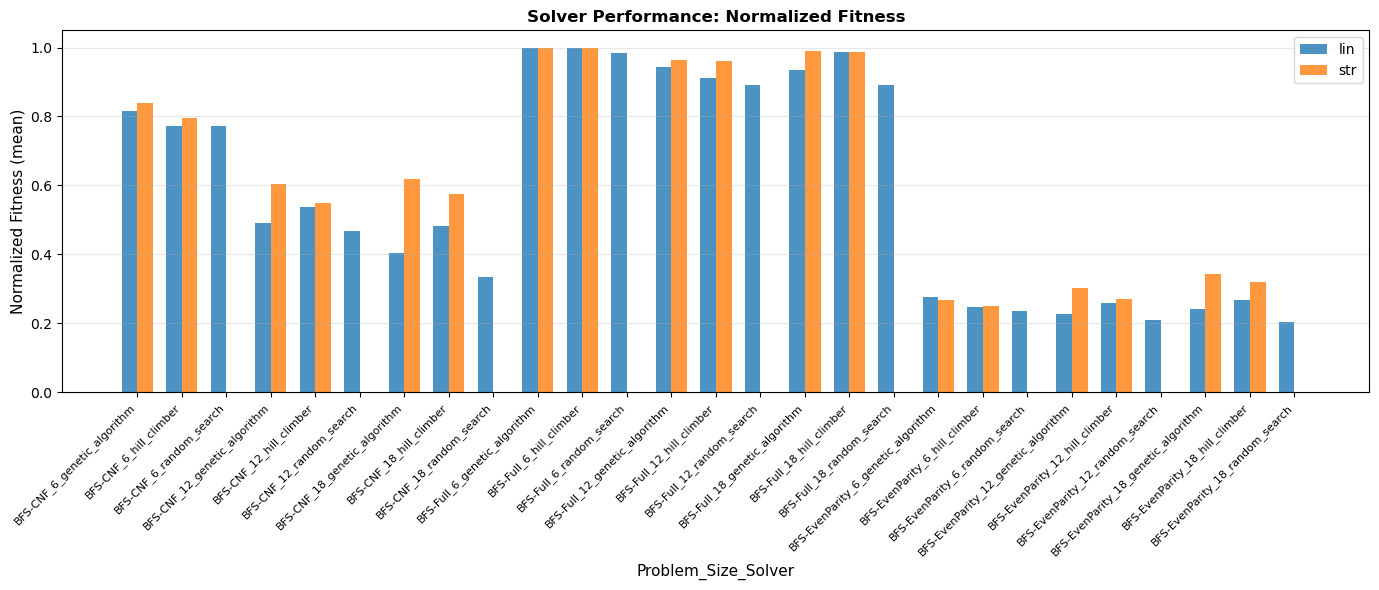

In [89]:
# Visualize solver performance using norm_fx
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Prepare data for plotting
plot_data = solver_summary.copy()

# Create x-axis labels combining problem, size, and solver
plot_data['problem_size_solver'] = (plot_data['problem'].astype(str) + '_' + 
                                     plot_data['size'].astype(str) + '_' + 
                                     plot_data['solver'])

# Get unique problem_size_solver combinations in order
problem_size_solvers = plot_data['problem_size_solver'].unique()

# Set up bar positions
x = np.arange(len(problem_size_solvers))
width = 0.35

# Separate data by name_type
lin_data = plot_data[plot_data['name_type'] == 'lin'].set_index('problem_size_solver')['norm_fx_mean']
str_data = plot_data[plot_data['name_type'] == 'str'].set_index('problem_size_solver')['norm_fx_mean']

# Align data with problem_size_solvers order
lin_values = [lin_data.get(ps, 0) for ps in problem_size_solvers]
str_values = [str_data.get(ps, 0) for ps in problem_size_solvers]

# Create bars
ax.bar(x - width/2, lin_values, width, label='lin', alpha=0.8)
ax.bar(x + width/2, str_values, width, label='str', alpha=0.8)

# Formatting
ax.set_xlabel('Problem_Size_Solver', fontsize=11)
ax.set_ylabel('Normalized Fitness (mean)', fontsize=11)
ax.set_title('Solver Performance: Normalized Fitness', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(problem_size_solvers, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/solver_norm_fx_barplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from skgstat import Variogram

In [ ]:
make_variogram(x, y)